In [403]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as smg
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler
import arviz as az


settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5,
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

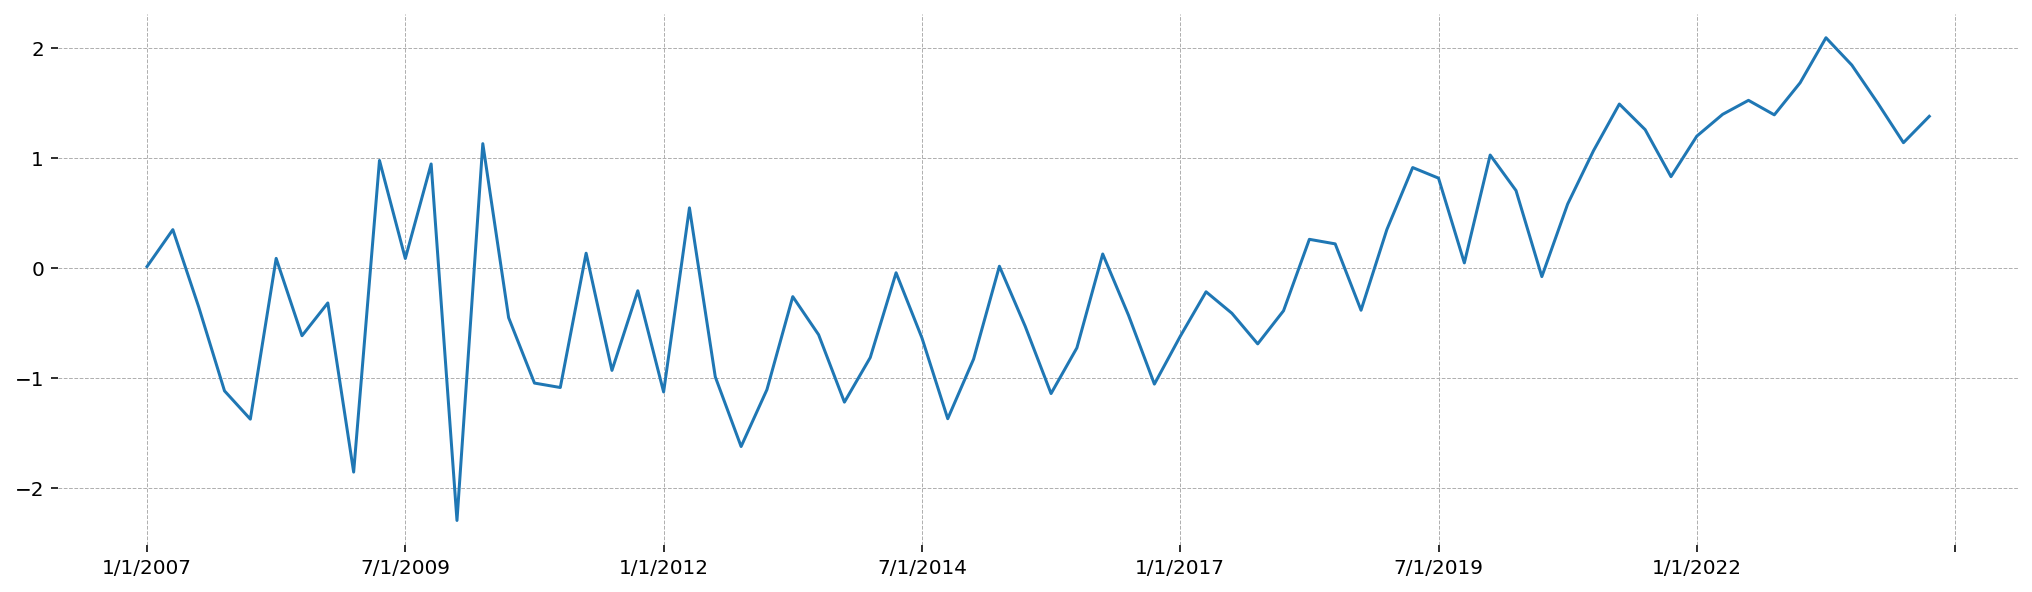

In [404]:
data = pd.read_csv(r'../data/startups.csv', index_col=[0], date_format="mm/dd/yyyy")
data.rename(columns = {'All Economic Activities, Total Business Start-Ups': 'Startups'}, inplace = True)

data['Startups_stdz'] = data['Startups'].transform(lambda x: (x - x.mean()) / x.std())

data = data.dropna(subset=["Startups_stdz"])
data['Startups_stdz'].plot()

y_data = data['Startups_stdz'].values
T = y_data.shape[0]
t_data = np.arange(T)

In [405]:
n_order = 3
periods = np.array(t_data) / 365.25

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

In [406]:
horizon = 12
forecasts = T + horizon

def make_latent_AR_trend_seasonal_model(ar_data, ff, priors, prediction_steps=forecasts, full_sample=True, samples=2000):
    with pm.Model() as AR:
        pass

    ff = ff.to_numpy().T
    AR.add_coord("obs_id", t_data)
    ## The fourier features must be mutable to allow for addition fourier features to be
    ## passed in the prediction step.
    AR.add_coord("fourier_features", np.arange(len(ff)))

    with AR:
        ## Data containers to enable prediction
        t = pm.Data("t", t_data, dims="obs_id")
        y = pm.Data("y", y_data, dims="obs_id")
        # The first coefficient will be the intercept term
        coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
        sigma = pm.HalfNormal("sigma", priors["sigma"])
        # We need one init variable for each lag, hence size is variable too
        init = pm.Normal.dist(priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"])
        # Steps of the AR model minus the lags required given specification
        ar1 = pm.AR(
            "ar",
            coefs,
            sigma=sigma,
            init_dist=init,
            constant=True,
            steps=t.shape[0] - (priors["coefs"]["size"] - 1),
            dims="obs_id",
        )

        ## Priors for the linear trend component
        alpha = pm.Normal("alpha", priors["alpha"]["mu"], priors["alpha"]["sigma"])
        beta = pm.Normal("beta", priors["beta"]["mu"], priors["beta"]["sigma"])
        trend = pm.Deterministic("trend", alpha + beta * t, dims="obs_id")

        ## Priors for seasonality
        beta_fourier = pm.Normal(
            "beta_fourier",
            mu=priors["beta_fourier"]["mu"],
            sigma=priors["beta_fourier"]["sigma"],
            dims="fourier_features",
        )
        fourier_terms = pm.Data("fourier_terms", ff)
        seasonality = pm.Deterministic("seasonality", pm.math.dot(beta_fourier, fourier_terms), dims="obs_id")

        mu = ar1 + trend + seasonality

        # The Likelihood
        outcome = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y, dims="obs_id")
        ## Sampling
        idata_ar = pm.sample_prior_predictive()
        if full_sample:
            idata_ar.extend(pm.sample(samples, target_accept=0.95))
            idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
        else:
            return idata_ar

    n = prediction_steps - y_data.shape[0]
    n_order = 3
    periods = (y_data.shape[0] + np.arange(n)) / 365.25

    fourier_features_new = pd.DataFrame(
        {
            f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
            for order in range(1, n_order + 1)
            for func in ("sin", "cos")
        }
    )

    with AR:
        AR.add_coords({"obs_id_fut_1": range(y_data.shape[0] - 1, prediction_steps, 1)})
        AR.add_coords({"obs_id_fut": range(y_data.shape[0], prediction_steps, 1)})
        t_fut = pm.Data("t_fut", list(range(y_data.shape[0], prediction_steps, 1)), dims="obs_id_fut")
        ff_fut = pm.Data("ff_fut", fourier_features_new.to_numpy().T)
        # condition on the learned values of the AR process
        # initialise the future AR process precisely at the last observed value in the AR process
        # using the special feature of the dirac delta distribution to be 0 probability everywhere else.
        ar1_fut = pm.AR(
            "ar1_fut",
            init_dist=pm.DiracDelta.dist(ar1[..., -1]),
            rho=coefs,
            sigma=sigma,
            constant=True,
            dims="obs_id_fut_1",
        )
        trend = pm.Deterministic("trend_fut", alpha + beta * t_fut, dims="obs_id_fut")
        seasonality = pm.Deterministic("seasonality_fut", pm.math.dot(beta_fourier, ff_fut), dims="obs_id_fut")
        mu = ar1_fut[1:] + trend + seasonality

        yhat_fut = pm.Normal("yhat_fut", mu=mu, sigma=sigma, dims="obs_id_fut")

        # use the updated values and predict outcomes and probabilities:
        idata_preds = pm.sample_posterior_predictive(idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True)

    return idata_ar, idata_preds, AR

In [407]:
priors_0 = {
    "coefs": {"mu": [0.2, -0.1], "sigma": [0.1, 0.1], "size": 2},
    "alpha": {"mu": -0.6, "sigma": 0.2},
    "beta": {"mu": 0.05, "sigma": 0.03},
    "beta_fourier": {"mu": 0.0, "sigma": 1.0},
    "sigma": 0.02,
    "init": {"mu": -0.01, "sigma": 0.2, "size": 1},
}

idata_t_s, preds_t_s, model = make_latent_AR_trend_seasonal_model(y_data, fourier_features, priors_0)

Sampling: [alpha, ar, beta, beta_fourier, coefs, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma, ar, alpha, beta, beta_fourier]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 219 seconds.
Sampling: [likelihood]


Output()

Sampling: [ar1_fut, likelihood, yhat_fut]


Output()

In [408]:
az.summary(idata_t_s, var_names=["alpha", "beta", "coefs", "beta_fourier"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.604,0.197,-0.980,-0.246,0.002,0.002,7744.0,5930.0,1.0
beta,0.045,0.030,-0.008,0.103,0.000,0.000,7149.0,6002.0,1.0
coefs[0],0.183,0.098,-0.001,0.362,0.003,0.002,1133.0,2265.0,1.0
coefs[1],-0.137,0.093,-0.310,0.036,0.001,0.001,4437.0,5350.0,1.0
beta_fourier[0],-3.104,6.705,-16.153,8.825,0.136,0.096,2429.0,3620.0,1.0
beta_fourier[1],-2.835,5.216,-12.838,6.852,0.107,0.075,2387.0,3548.0,1.0
beta_fourier[2],5.538,6.536,-6.678,17.824,0.124,0.087,2798.0,4079.0,1.0
beta_fourier[3],2.756,6.391,-9.628,14.504,0.135,0.096,2229.0,3174.0,1.0
beta_fourier[4],-3.794,2.764,-8.797,1.501,0.052,0.037,2840.0,4430.0,1.0
beta_fourier[5],0.344,1.992,-3.426,4.133,0.041,0.029,2362.0,3553.0,1.0


In [409]:
def plot_fits(idata_ar, idata_preds):
    palette = "plasma"
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    mosaic = """AABB
                CCCC"""
    fig, axs = plt.subplot_mosaic(mosaic, sharex=False, figsize=(20, 10))
    axs = [axs[k] for k in axs.keys()]
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[0].fill_between(
            x=idata_ar["constant_data"]["t"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[0].plot(
        az.extract(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"].mean(axis=1),
        color="cyan",
        label="Prior Predicted Mean Realisation",
    )

    axs[0].scatter(
        x=idata_ar["constant_data"]["t"],
        y=idata_ar["constant_data"]["y"],
        color="k",
        label="Observed Data points",
    )
    axs[0].set_title("Prior Predictive Fit", fontsize=20)
    axs[0].legend()

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract(idata_preds, group="predictions", num_samples=1000)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract(idata_preds, group="predictions", num_samples=1000)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=idata_preds["predictions_constant_data"]["t"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

        upper = np.percentile(
            az.extract(idata_preds, group="predictions", num_samples=1000)["yhat_fut"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract(idata_preds, group="predictions", num_samples=1000)["yhat_fut"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=idata_preds["predictions"].coords["obs_id_fut"].data,
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[2].plot(
        az.extract(idata_preds, group="predictions", num_samples=1000)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
    )
    idata_preds.predictions.yhat_fut.mean(["chain", "draw"]).plot(
        ax=axs[2], color="cyan", label="Predicted Mean Realisation"
    )
    axs[2].scatter(
        x=idata_ar["constant_data"]["t"],
        y=idata_ar["constant_data"]["y"],
        color="k",
        label="Observed Data",
    )
    axs[2].set_title("Posterior Predictions Plotted", fontsize=20)
    axs[2].axvline(np.max(idata_ar["constant_data"]["t"]), color="black")
    axs[2].legend()
    axs[2].set_xlabel("Time in Days")
    axs[0].set_xlabel("Time in Days")
    az.plot_ppc(idata_ar, ax=axs[1])


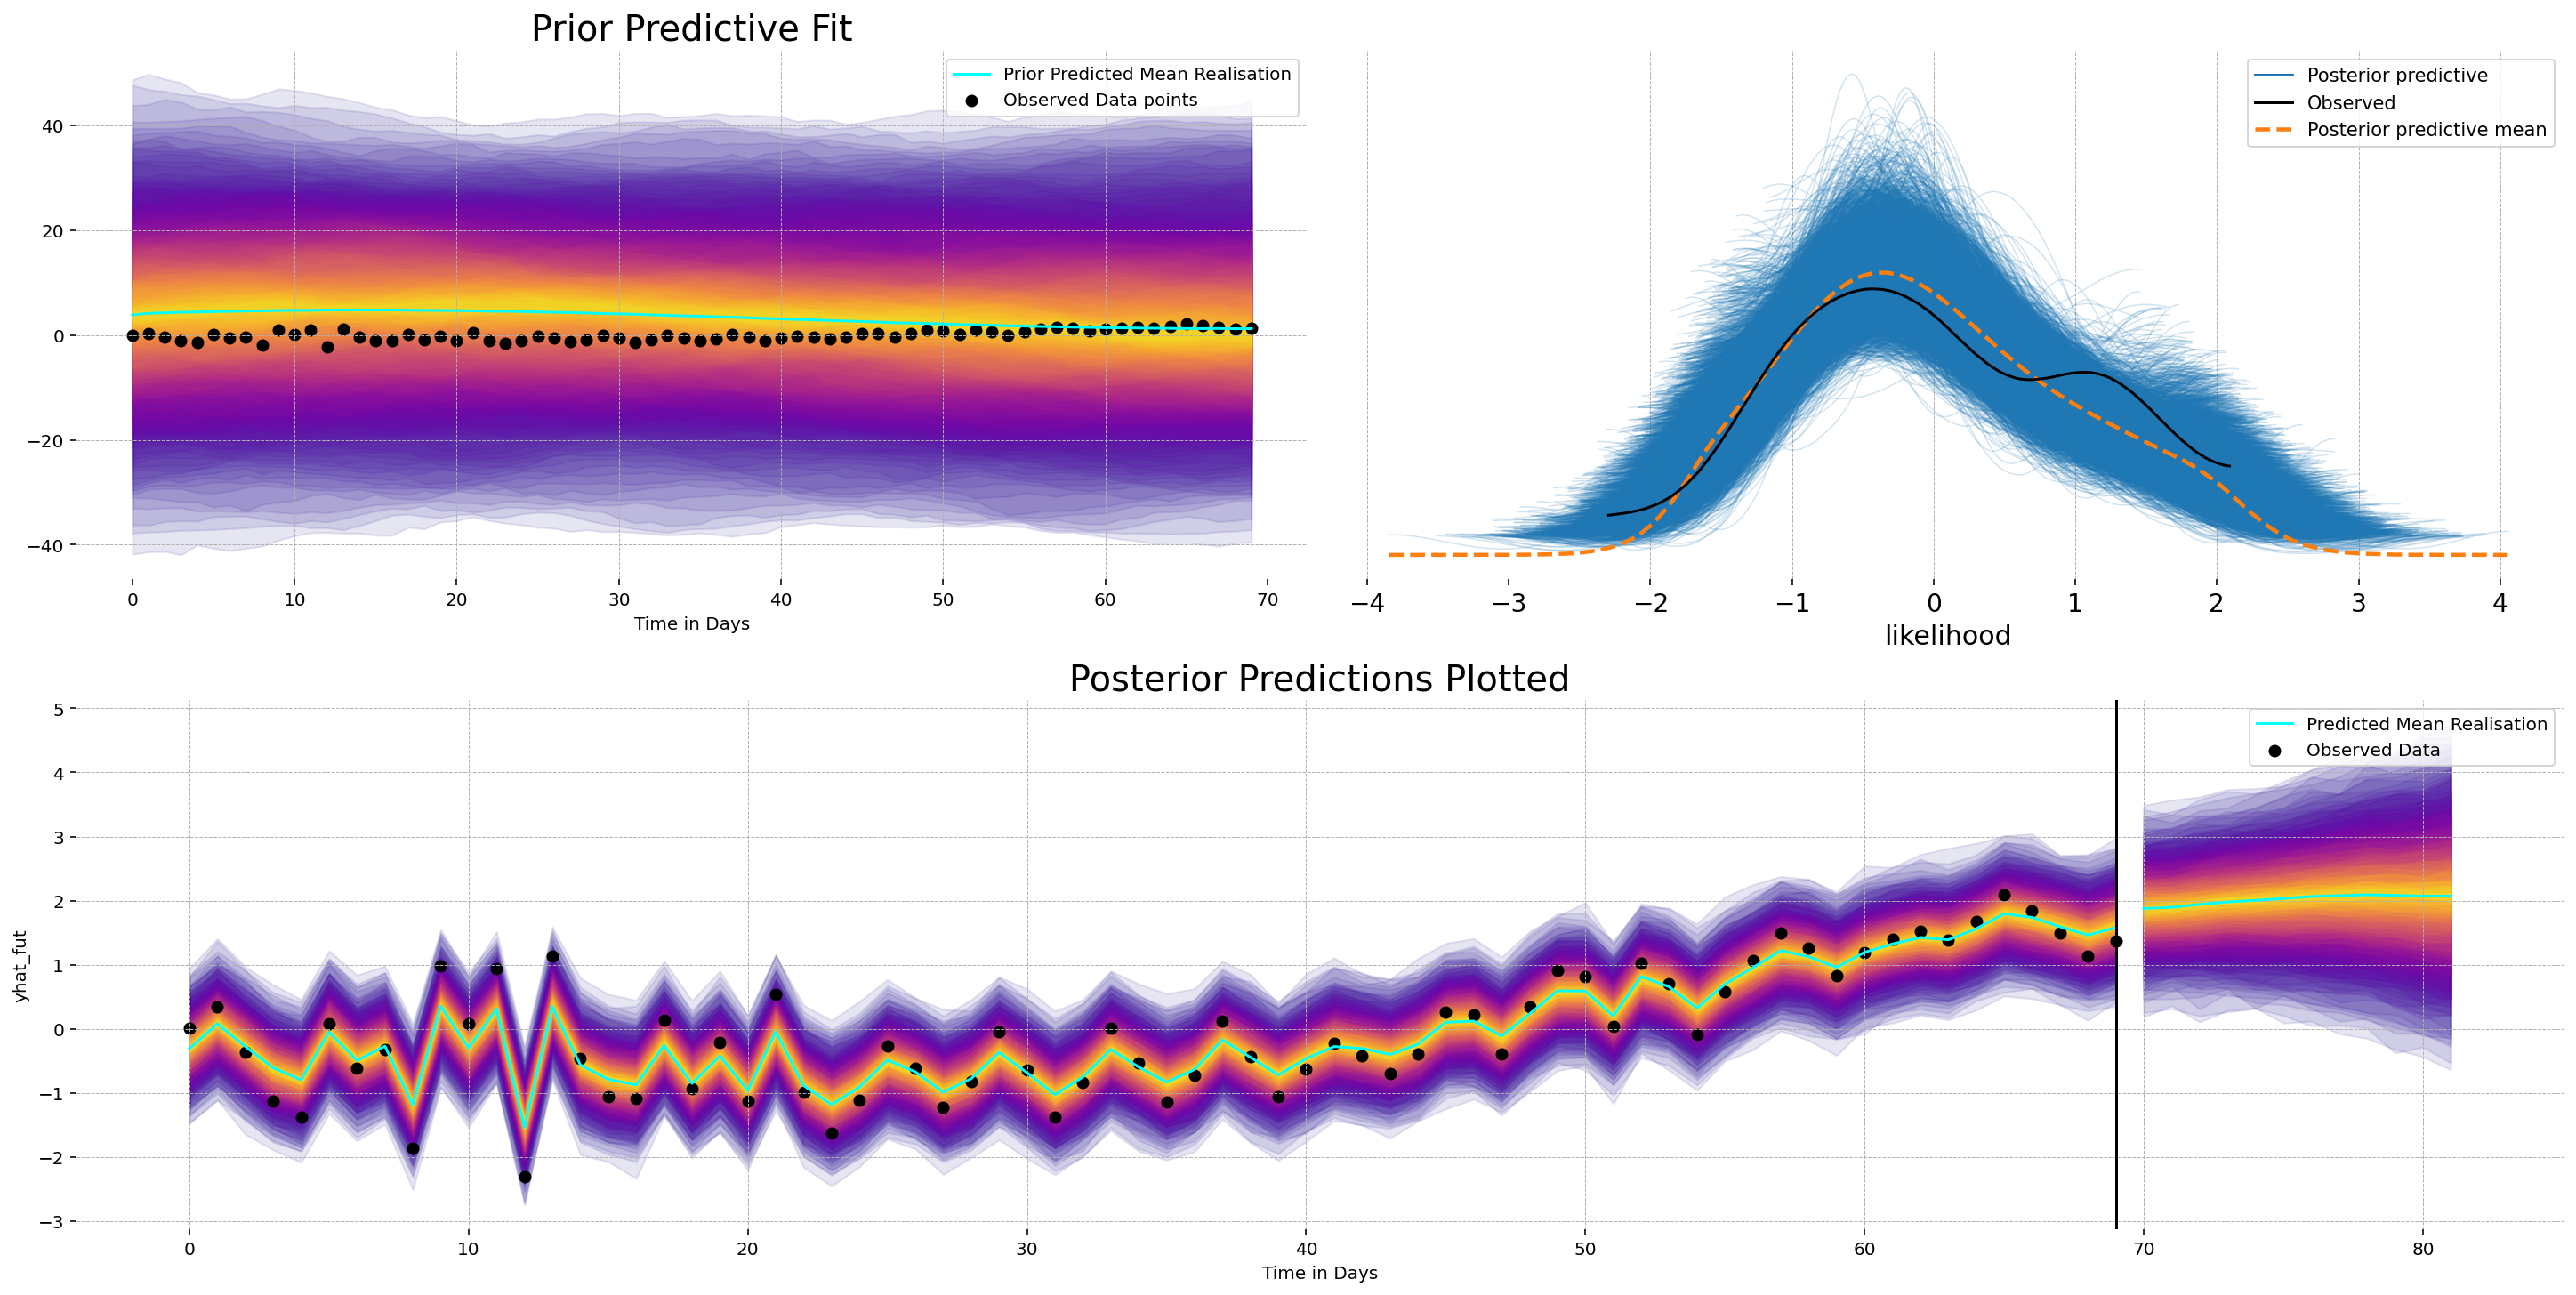

In [410]:
plot_fits(idata_t_s, preds_t_s)

In [411]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

AttributeError: 'InferenceData' object has no attribute 'observed_data'

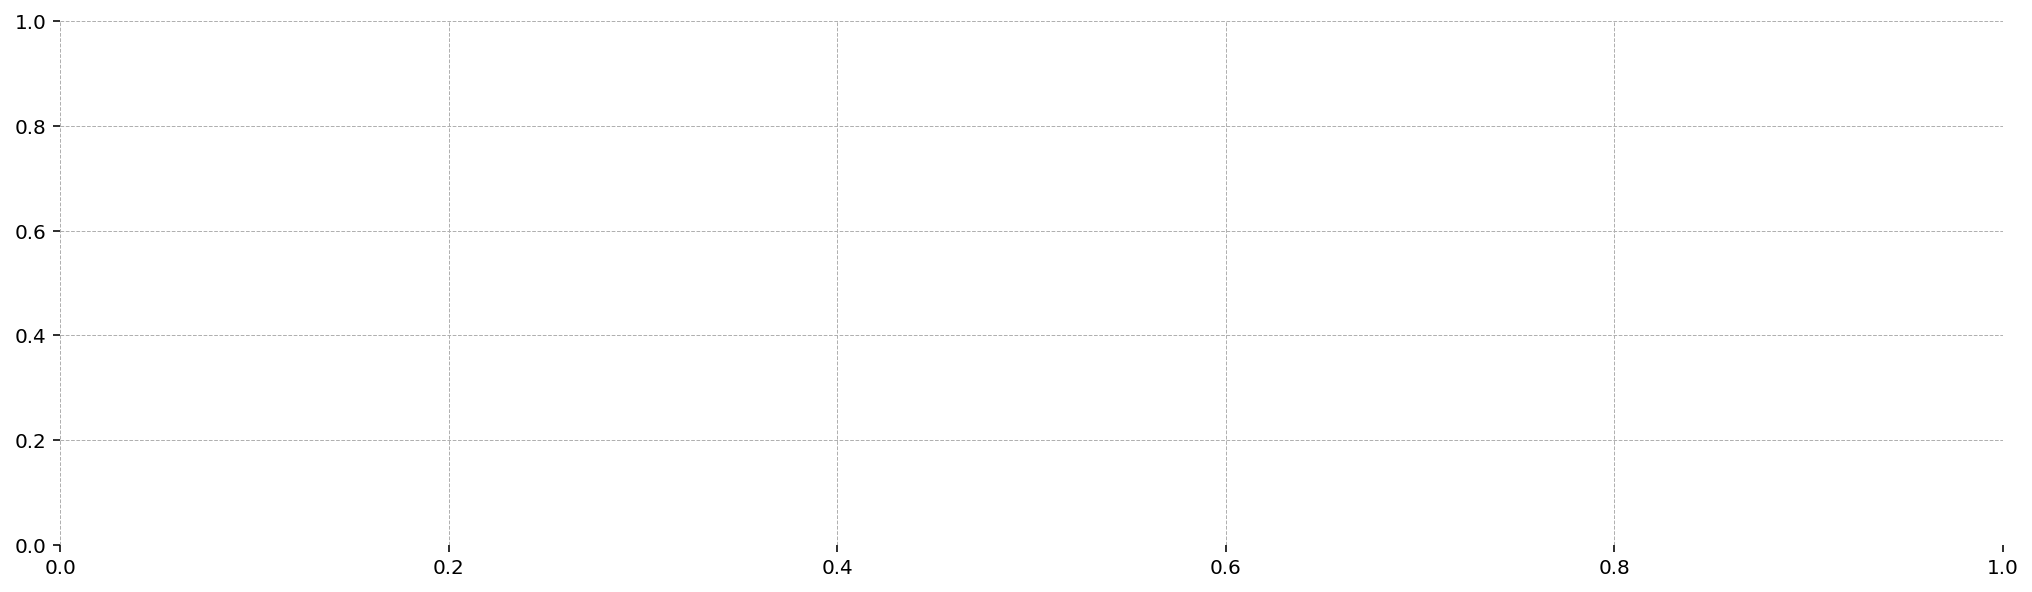

In [412]:
plot_results(preds_t_s, oos_name='Predictions')